In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn import metrics
import joblib                                                                                                                                            
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import f1_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import auc
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from scipy.stats import pearsonr
from collections import Counter

In [2]:
data = pd.read_table('。。/data-2/total4.15.txt',sep='\t',index_col=0)

data_gt= data.loc[:, data.columns.str.contains('BC|NT|MC|PC')].T
data_gt = data_gt.apply(pd.to_numeric)
data_gt = data_gt.drop(index=['BC5.1', 'BC5.3'])
data_gt = data_gt.apply(pd.to_numeric)
data_gt.fillna(0, inplace=True)
data_gt.columns = data['ID']
# data_gt

data_fjg= data.loc[:, ~data.columns.str.contains('BC|NT|MC|PC')].T
data_fjg.columns = data_fjg.iloc[0]
data_fjg = data_fjg[1:]
data_fjg = data_fjg.sort_index()
data_fjg = data_fjg.replace("#DIV/0!", 0)
data_fjg = data_fjg.apply(pd.to_numeric)
data_fjg.fillna(0, inplace=True) 
# data_fjg

In [3]:

pearson_corr_values = []
for i in range(len(data_fjg)):
    corr_values = []
    for j in range(len(data_gt)):
        corr, _ = pearsonr(data_fjg.iloc[i], data_gt.iloc[j])
        corr_values.append(corr)
    pearson_corr_values.append(corr_values)


pearson_corr_matrix = pd.DataFrame(pearson_corr_values, index=data_fjg.index, columns=data_gt.index)
pearson_corr_matrix['sum'] = pearson_corr_matrix.sum(axis=1)
# pearson_corr_matrix


pearson_corr_matrix['label'] = np.where(pearson_corr_matrix['sum'] > 1.5, 1, 0) 
# similarity_matrix
len(pearson_corr_matrix[pearson_corr_matrix['label'] == 1])


data = pd.concat([data_fjg, data_gt])
data = data.loc[:, (data != 0).any(axis=0)]
X = data

Y = pearson_corr_matrix['label'].tolist() + [1] * len(data_gt)
Y = np.array(Y)

print(X.shape,Y.shape) 
Counter(Y)


(89, 2537) (89,)


Counter({0: 45, 1: 44})

In [4]:

X  = Normalizer().fit_transform(X)
# X  = StandardScaler().fit_transform(X)
X  = MinMaxScaler().fit_transform(X)

In [5]:
rfc = RFC(n_estimators=4,random_state=42)
n = 7
sfm = SelectFromModel(rfc, max_features = n) #12-0.031
X_sn_new = sfm.fit_transform(X, Y)
print(X_sn_new.shape)

feature_importance = sfm.estimator_.feature_importances_
non_zero_indices = sfm.get_support(indices=True)
non_zero_indices = non_zero_indices.tolist()
all_f = data.columns.tolist()
feature = [all_f[i] for i in non_zero_indices]
print(len(feature),feature)

for i in feature:
    print(i)
    
X_k = X[:, non_zero_indices]
print(X_k.shape,Y.shape)

for i in non_zero_indices:
    print(i,feature_importance[i])


(89, 7)
7 ['4602-84-0', '590-86-3', '1014-60-4', '6114-18-7', '110-38-3', '1000152-34-3', '1000377-93-5']
4602-84-0
590-86-3
1014-60-4
6114-18-7
110-38-3
1000152-34-3
1000377-93-5
(89, 7) (89,)
385 0.10333139834881319
648 0.05883516842970881
798 0.06120840042941493
943 0.11812073729978186
1171 0.041489529604979536
1688 0.107121172136652
1852 0.07509362767238785


In [94]:

# new = non_zero_indices[1:]
# new = non_zero_indices[:1] + non_zero_indices[2:]
# new = non_zero_indices[:2] + non_zero_indices[3:]
# new = non_zero_indices[:3] + non_zero_indices[4:]
# new = non_zero_indices[:4] + non_zero_indices[5:]
# new = non_zero_indices[:5] + non_zero_indices[6:]
new = non_zero_indices[:6] + non_zero_indices[7:]

# # new = non_zero_indices[:7] + non_zero_indices[8:]
# new = non_zero_indices[:8] + non_zero_indices[9:]
X_k = X[:, new]
print(X_k.shape,Y.shape)

feature = [all_f[i] for i in new]
print(len(feature),feature)
# for i in feature:
#     print(i)
new,non_zero_indices

(89, 6) (89,)
6 ['4602-84-0', '590-86-3', '1014-60-4', '6114-18-7', '123-69-3', '1000152-34-3']


([385, 648, 798, 943, 1389, 1688], [385, 648, 798, 943, 1389, 1688, 1852])

In [6]:

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

accuracies = []
f1_scores = []
auc_scores = []
recall = []
precision = []
tpr_list = []
fpr_list = []

accuracies_train = []
f1_scores_train = []
auc_scores_train = []
recall_train = []
precision_train = []
tpr_list_train = []
fpr_list_train = []

for train_idx, test_idx in cv.split(X_k, Y):
    X_train, X_test = X_k[train_idx], X_k[test_idx]
    Y_train, Y_test = Y[train_idx], Y[test_idx]
    rfc.fit(X_train, Y_train)
    #train
    X_pred = rfc.predict(X_train)
    accuracy = accuracy_score(Y_train, X_pred)
    re = metrics.recall_score(Y_train, X_pred)
    pr = metrics.precision_score(Y_train, X_pred)
    f1 = f1_score(Y_train, X_pred)
    auc1 = roc_auc_score(Y_train, rfc.predict_proba(X_train)[:,1])
    fpr, tpr, _ = roc_curve(Y_train,  rfc.predict_proba(X_train)[:,1])

    accuracies_train.append(accuracy)
    f1_scores_train.append(f1)
    auc_scores_train.append(auc1)
    recall_train.append(re)
    precision_train.append(pr)
    tpr_list_train.append(tpr)
    fpr_list_train.append(fpr)

    #test
    Y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(Y_test, Y_pred)
    re = metrics.recall_score(Y_test, Y_pred)
    pr = metrics.precision_score(Y_test, Y_pred)
    f1 = f1_score(Y_test, Y_pred)
    auc1 = roc_auc_score(Y_test, rfc.predict_proba(X_test)[:,1])
    fpr, tpr, _ = roc_curve(Y_test,  rfc.predict_proba(X_test)[:,1])
    tpr_list.append(tpr)
    fpr_list.append(fpr)
    accuracies.append(accuracy)
    recall.append(re)
    precision.append(pr)
    f1_scores.append(f1)
    auc_scores.append(auc1)

# print("Train result")

for i, (accuracy,re, f1, auc) in enumerate(zip(accuracies_train, recall_train,f1_scores_train, auc_scores_train), 1):
    print(f'Fold {i}: Accuracy = {accuracy:.4f}, Recall = {re:.4f},F1 Score = {f1:.4f}, AUC = {auc:.4f}')


average_accuracy = sum(accuracies_train) / len(accuracies_train)
average_recall = sum(recall_train) / len(recall_train)
average_f1 = sum(f1_scores_train) / len(f1_scores_train)
average_auc = sum(auc_scores_train) / len(auc_scores_train)
average_precision = sum(precision_train) / len(precision_train)


print(f'Average Accuracy = {average_accuracy:.4f}')
print(f'Average Recall = {average_recall:.4f}')
print(f'Average Precision = {average_precision:.4f}')
print(f'Average F1 Score = {average_f1:.4f}')
print(f'Average AUC = {average_auc:.4f}')

Fold 1: Accuracy = 0.9750, Recall = 0.9500,F1 Score = 0.9744, AUC = 0.9953
Fold 2: Accuracy = 0.9750, Recall = 0.9750,F1 Score = 0.9750, AUC = 0.9991
Fold 3: Accuracy = 0.9500, Recall = 0.9250,F1 Score = 0.9487, AUC = 0.9922
Fold 4: Accuracy = 0.9625, Recall = 0.9500,F1 Score = 0.9620, AUC = 0.9791
Fold 5: Accuracy = 0.9750, Recall = 0.9750,F1 Score = 0.9750, AUC = 0.9959
Fold 6: Accuracy = 0.9750, Recall = 0.9744,F1 Score = 0.9744, AUC = 0.9959
Fold 7: Accuracy = 0.9750, Recall = 0.9744,F1 Score = 0.9744, AUC = 0.9950
Fold 8: Accuracy = 0.9750, Recall = 0.9744,F1 Score = 0.9744, AUC = 0.9987
Fold 9: Accuracy = 0.9625, Recall = 0.9487,F1 Score = 0.9610, AUC = 0.9950
Fold 10: Accuracy = 0.9753, Recall = 1.0000,F1 Score = 0.9756, AUC = 0.9930
Average Accuracy = 0.9700
Average Recall = 0.9647
Average Precision = 0.9747
Average F1 Score = 0.9695
Average AUC = 0.9939


In [7]:
# print("Test result")

for i, (accuracy,re, f1, auc) in enumerate(zip(accuracies, recall,f1_scores, auc_scores), 1):
    print(f'Fold {i}: Accuracy = {accuracy:.4f}, Recall = {re:.4f},F1 Score = {f1:.4f}, AUC = {auc:.4f}')


average_accuracy = sum(accuracies) / len(accuracies)
average_recall = sum(recall) / len(recall)
average_f1 = sum(f1_scores) / len(f1_scores)
average_auc = sum(auc_scores) / len(auc_scores)
average_precision = sum(precision) / len(precision)
print(f'Average Accuracy = {average_accuracy:.4f}')
print(f'Average Recall = {average_recall:.4f}')
print(f'Average Precision = {average_precision:.4f}')
print(f'Average F1 Score = {average_f1:.4f}')
print(f'Average AUC = {average_auc:.4f}')

Fold 1: Accuracy = 0.7778, Recall = 0.7500,F1 Score = 0.7500, AUC = 0.6750
Fold 2: Accuracy = 0.8889, Recall = 1.0000,F1 Score = 0.8889, AUC = 0.8750
Fold 3: Accuracy = 0.8889, Recall = 0.7500,F1 Score = 0.8571, AUC = 1.0000
Fold 4: Accuracy = 0.8889, Recall = 0.7500,F1 Score = 0.8571, AUC = 0.8750
Fold 5: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 6: Accuracy = 0.8889, Recall = 0.8000,F1 Score = 0.8889, AUC = 0.9500
Fold 7: Accuracy = 0.8889, Recall = 0.8000,F1 Score = 0.8889, AUC = 1.0000
Fold 8: Accuracy = 1.0000, Recall = 1.0000,F1 Score = 1.0000, AUC = 1.0000
Fold 9: Accuracy = 0.7778, Recall = 0.8000,F1 Score = 0.8000, AUC = 0.7750
Fold 10: Accuracy = 0.8750, Recall = 1.0000,F1 Score = 0.8889, AUC = 1.0000
Average Accuracy = 0.8875
Average Recall = 0.8650
Average Precision = 0.9150
Average F1 Score = 0.8820
Average AUC = 0.9150


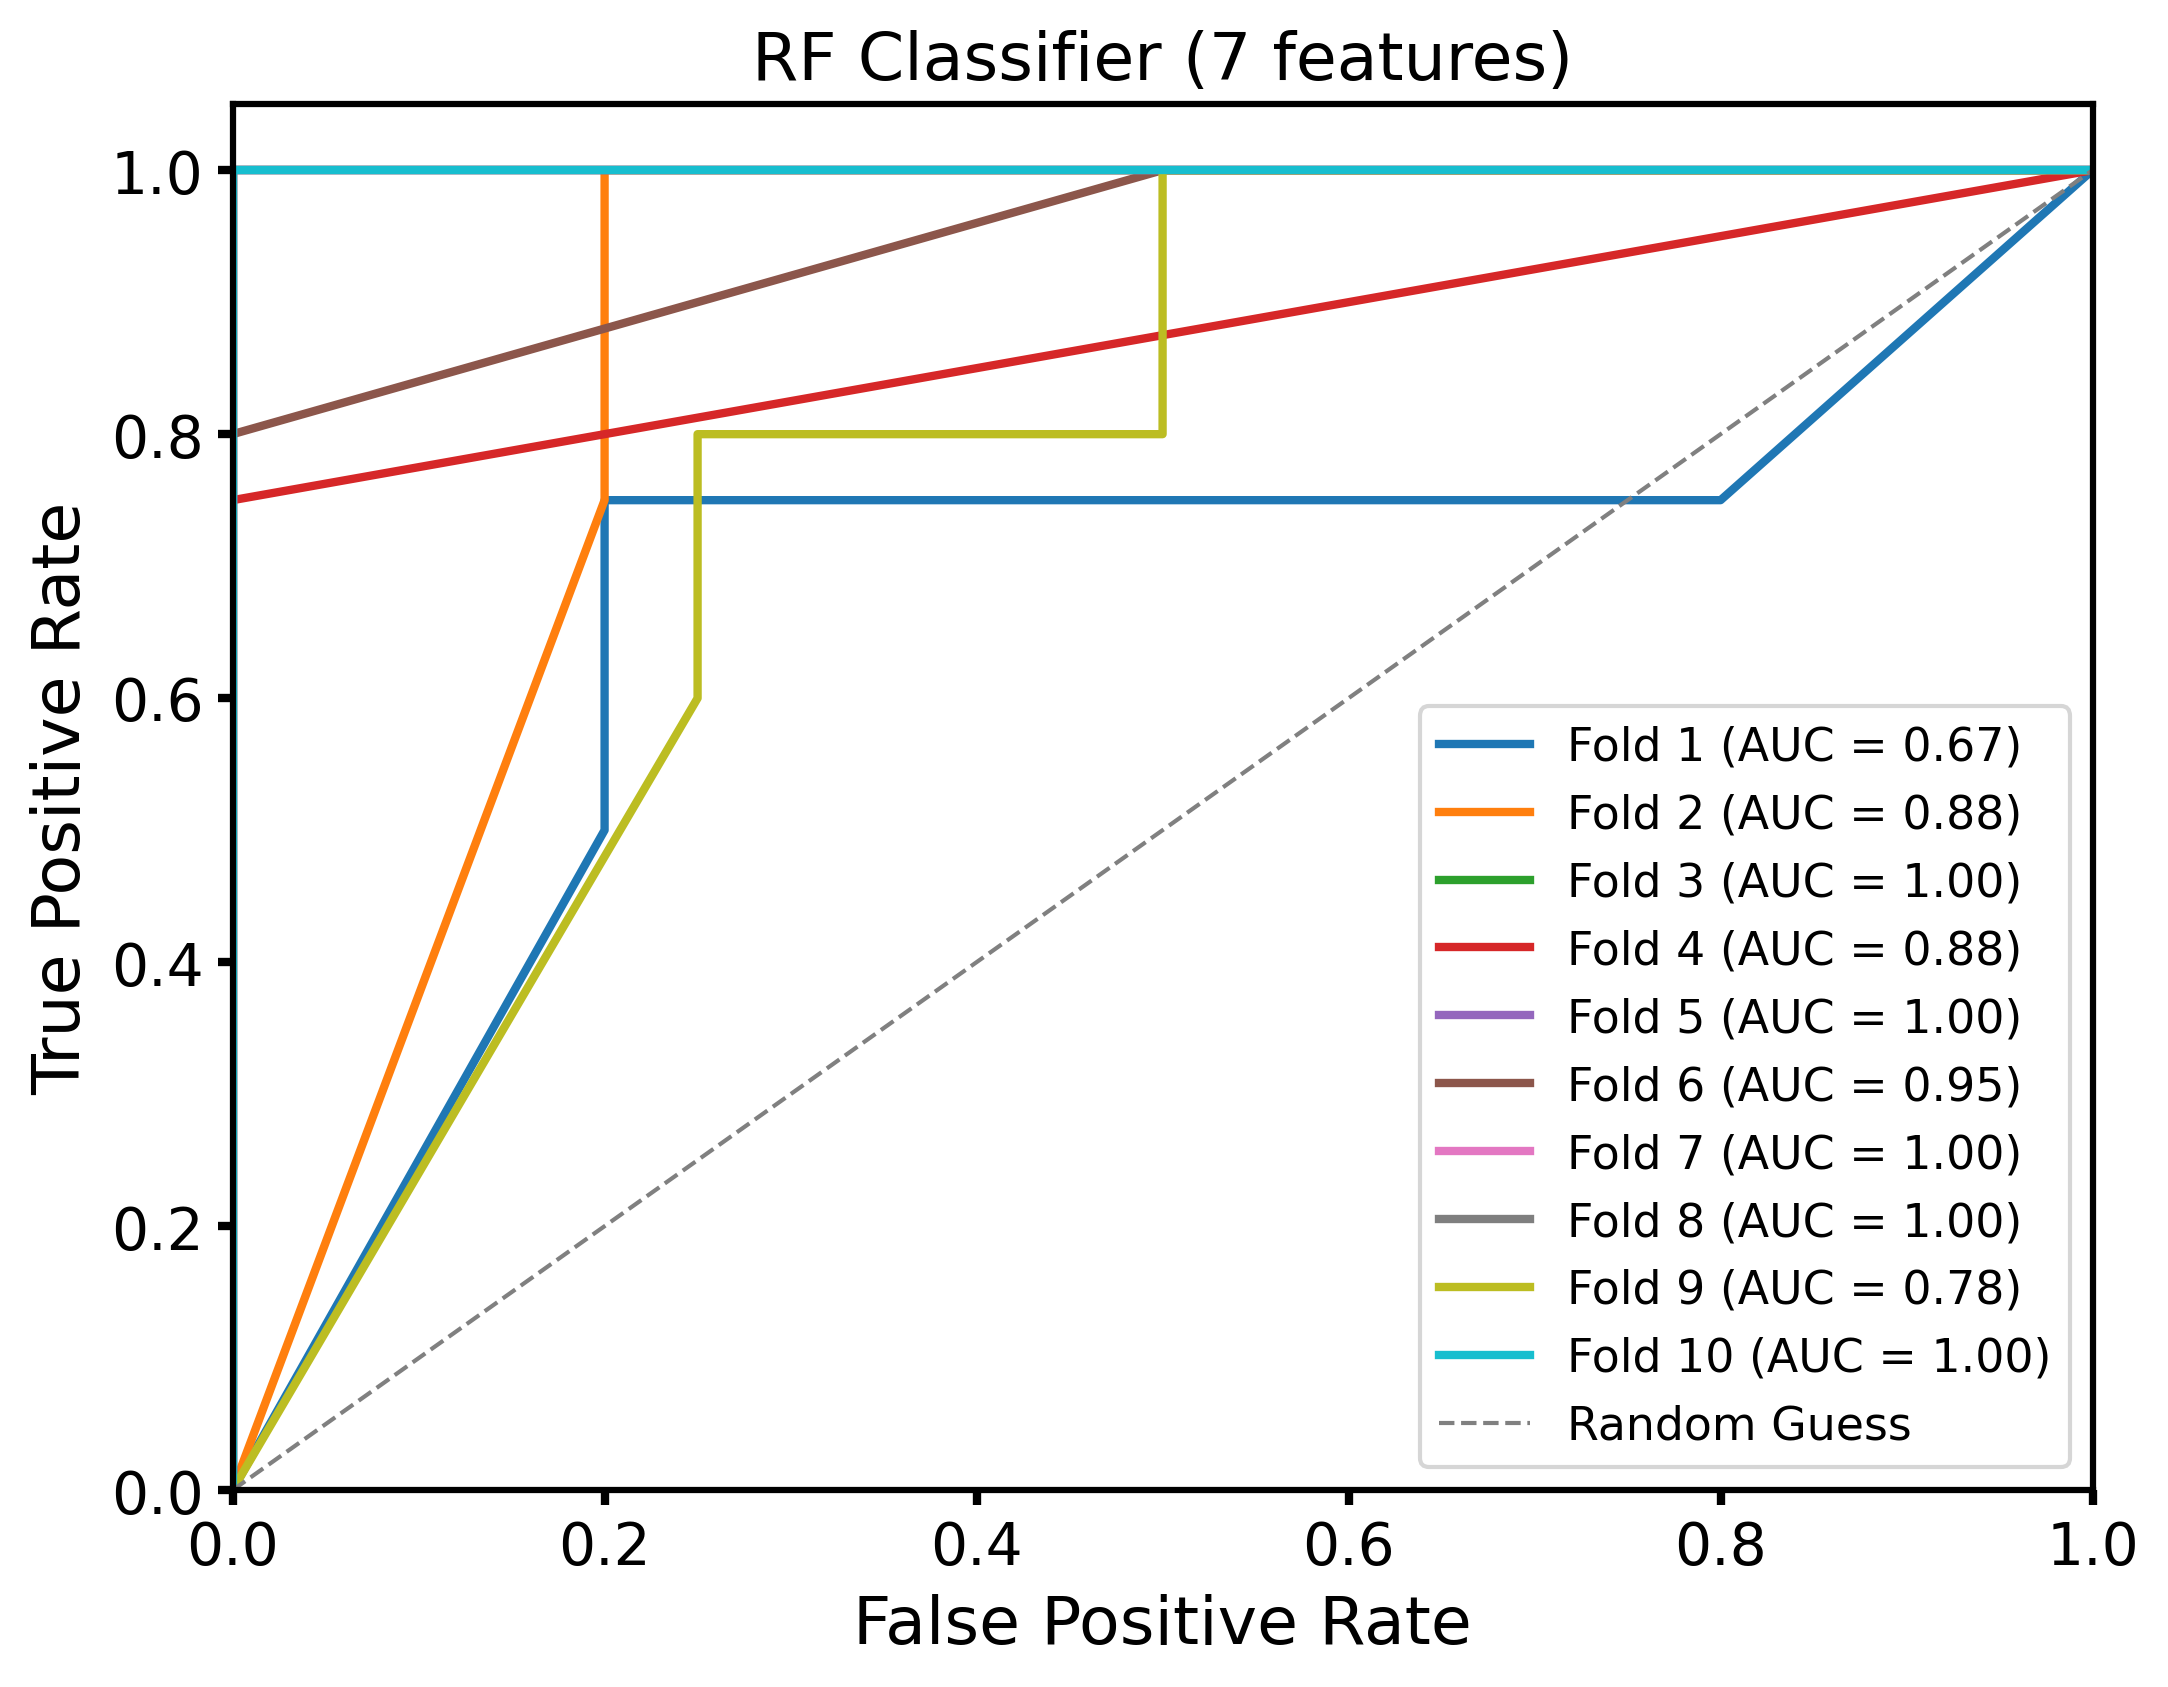

In [8]:

plt.figure(figsize=(8, 6),dpi=300)
for i, (tpr, fpr, roc_auc) in enumerate(zip(tpr_list, fpr_list, auc_scores), 1):
    plt.plot(fpr, tpr, lw=2, label=f'Fold {i} (AUC = {roc_auc:.2f})')


plt.plot([0, 1], [0, 1], linestyle='--', lw=1, color='grey', alpha=1,label='Random Guess')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('RF Classifier (7 features)', fontsize=16)
plt.legend(loc='lower right', fontsize=11)



plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)

plt.gca().tick_params(axis='both', which='major', width=2)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.savefig("../code-2/result/RFC-7F-ROC.pdf")
plt.savefig("../code-2/result/RFC-7F-ROC.png")
plt.show()

In [11]:
joblib.dump(rfc, "../code-2/result/RFC_Classifier-7f.joblib") #save model

['/data/public/dulin/fwwz/code-2/result/RFC_Classifier-7f.joblib']